# Machine Learning with PySpark on an EMR Cluster

In this notebook, we'll explore how you can use your PySpark coding skills to train a machine learning model on the [NYC Taxi Trip Record dataset on S3](https://registry.opendata.aws/nyc-tlc-trip-records-pds/). Note that this notebook is meant to be run on an EMR cluster, using a PySpark kernel.

First (after configuring our PySpark environment), let's load the data from S3 into our Spark session and install a few relevant libraries. The taxi data is spread across multiple parquet files, so we use the wildcard (\*) to indicate that we want the data from all of the files in a date range to be included within our dataframe, spread out over our EMR cluster in partitions. Here, we're going to be working with data from 2015, but we could specify other date ranges as well (going back to 2009) if we wanted to do so. We would just want to make sure our EMR cluster was big enough to efficiently work with all of the data.

In [ ]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

In [ ]:
sc.install_pypi_package("pandas==1.0.5")
sc.install_pypi_package("scipy==1.4.1")
sc.install_pypi_package("matplotlib==3.2.1")

In [3]:
import pyspark.sql.functions as F
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt

data = spark.read.parquet('s3://nyc-tlc/trip data/yellow_tripdata_2015*.parquet')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now that we have our data loaded in a DataFrame, let's take a look at its structure and contents. We can see that there is a lot of data here (146 million rows, which amounts to around 2 GB worth of compressed parquet data), but this is a small subset of the (\~26 GB) Yellow Cab dataset and the overall data from all ride shares, etc. (\~54 GB).

In [4]:
print('Total Columns: %d' % len(data.dtypes))
print('Total Rows: %d' % data.count())
data.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 19
Total Rows: 146039231
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)

And we can also see that each row in the dataset is an individual trip, followed by data about that trip:

In [5]:
data[['tpep_pickup_datetime', 'fare_amount', 'tip_amount']].show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------+----------+
|tpep_pickup_datetime|fare_amount|tip_amount|
+--------------------+-----------+----------+
| 2015-01-01 00:11:33|        5.7|       1.4|
| 2015-01-01 00:18:24|        6.0|       0.0|
| 2015-01-01 00:26:19|       13.2|       2.9|
| 2015-01-01 00:45:26|        8.2|      2.37|
| 2015-01-01 00:59:21|        6.0|       0.0|
| 2015-01-01 00:07:31|        5.0|       0.0|
| 2015-01-01 00:47:08|        7.0|       0.0|
| 2015-01-01 00:58:04|       12.2|       2.7|
| 2015-01-01 00:29:25|        7.0|       0.0|
| 2015-01-01 00:39:02|       18.0|       0.0|
| 2015-01-01 00:06:44|        5.5|       0.0|
| 2015-01-01 00:47:48|       11.7|       1.8|
| 2015-01-01 00:29:23|       10.0|       0.0|
| 2015-01-01 00:39:52|        4.0|      1.05|
| 2015-01-01 00:57:41|        9.0|       0.0|
| 2015-01-01 00:02:53|       17.7|       0.0|
| 2015-01-01 00:18:38|       13.2|       2.9|
| 2015-01-01 00:35:34|       18.2|       3.0|
| 2015-01-01 00:16:45|        6.5|

Now, let's say that over the course of our exploratory data analysis, we found a pattern such as the following -- hinting that weekend riders tip less than weekday riders.

In [6]:
data = data.withColumn('day_of_week', F.dayofweek(F.col('tpep_pickup_datetime'))) \
           .withColumn('weekend', F.col('day_of_week').isin({7, 1}).cast('integer'))
           

data.groupby('weekend') \
    .avg('tip_amount') \
    .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|weekend|   avg(tip_amount)|
+-------+------------------+
|      1|1.6500085049790578|
|      0|1.7615030303421926|
+-------+------------------+

We might then ask the question of how systematic this behavior is. To what extent does it being a weekend or not influence tip amount? 

The next step in our analysis might be to formally model this relationship and assess exactly how predictive weekend ridership is of diminished tip amount. For the rest of this notebook, we will train two simple, supervised machine learning models -- a linear regression model and a logistic regression model -- to do this using [Spark's MLlib library](https://spark.apache.org/docs/latest/ml-guide.html). MLlib has parallelized implementations of a wide variety of ML models and statistical tests in Spark for use with large data sources.

First, though, let's get our data ready to train these models. Because, we're going to train a logistic regression classifier in addition to a linear regression model, for instance, we will need to create a column in our dataset that can be used to assess whether a tip amount is "high" (1) or "low" (0). For the purposes of this demonstration, we will make this distinction based on whether a tip is above or below the average tip amount for this year (which we can see is around \$1.70):

In [7]:
data.filter((F.col('tip_amount') >= 0) 
            & (F.col('tip_amount') < 2000)) \
    .describe(['tip_amount']) \
    .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|        tip_amount|
+-------+------------------+
|  count|         146038222|
|   mean|1.7021448686214933|
| stddev|2.5878873169832586|
|    min|               0.0|
|    max|           1603.05|
+-------+------------------+

In [8]:
# to get output as a float, take the first row in the resulting Spark DataFrame
# and then extract the first (and only) element from that row
tip_average = data.filter((F.col('tip_amount') >= 0) 
            & (F.col('tip_amount') < 2000)) \
    .agg(F.avg(F.col('tip_amount'))) \
    .first()[0]

tip_average

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1.7021448686214933

In [9]:
# High == 1, Low == 0 (cast as integers so that pyspark.ml can understand them)
data = data.withColumn('high_tip', 
                       (F.col('tip_amount') >= tip_average).cast("integer"))

# Take a look at how many high and low tips we have, respectively
# Note that our data is a bit unbalanced -- ignoring for now, though
data.groupBy('high_tip') \
     .count() \
     .show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------+--------+
|high_tip|   count|
+--------+--------+
|       1|55991792|
|       0|90047439|
+--------+--------+

Then, let's use the `VectorAssembler` to get our `weekend` feature into a form that `pyspark.ml` expects it to be in (as per the DataCamp tutorial).

In [10]:
features = ['weekend']
assembler = VectorAssembler(inputCols=features, outputCol='features')

data = assembler.transform(data)
data[['tip_amount', 'high_tip', 'weekend', 'features']].show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+-------+--------+
|tip_amount|high_tip|weekend|features|
+----------+--------+-------+--------+
|       1.4|       0|      0|   [0.0]|
|       0.0|       0|      0|   [0.0]|
|       2.9|       1|      0|   [0.0]|
|      2.37|       1|      0|   [0.0]|
|       0.0|       0|      0|   [0.0]|
+----------+--------+-------+--------+
only showing top 5 rows

We're now ready to train our linear regression model (with `tip_amount` as our outcome) and logistic regression model (with `high_tip` as our outcome).

Let's split up our data into training and test data and train our models on the training data. Note, for the sake of this demonstration, we are sampling a small fraction of our data (so that you don't need to use too large of an EMR cluster size to run this code). When you're testing a Machine Learning workflow, this can be effective strategy to make sure your code works before scaling up to the full dataset with a larger cluster (you can request up to 32 vCPUs to run concurrently in AWS Academy -- i.e. 1 m5.xlarge primary node and 7 m5.xlarge core nodes).

In [11]:
sampled_data = data.sample(fraction=0.001, seed=0)

# split into train/test data
train, test = sampled_data.randomSplit([0.8, 0.2], seed=0)

# Persist data in memory to speed up I/O during training/testing
train.persist()
test.persist()

# confirm they're cached
print(train.is_cached, test.is_cached)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

True True

We're then ready to train our models. Let's train our linear regression model first and print out some metrics to summarize the trained model (for more available metrics consult the documentation for the [LinearRegressionModel](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegressionModel.html) and [LinearRegressionTrainingSummary](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegressionTrainingSummary.html) classes ):

In [12]:
lir = LinearRegression(featuresCol='features', labelCol='tip_amount')
lir_model = lir.fit(train)

# Summarize trained model
print(f'Coefficients: {lir_model.coefficients}')
print(f'P-values (last number is intercept): {lir_model.summary.pValues}')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Coefficients: [-0.2241609312902808]
P-values (last number is intercept): [0.0, 0.0]

We can then evaluate the performance of our model by making predictions using the features in our test data. You can consult the documentation for the [LinearRegressionSummary](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegressionSummary.html) class for more detailed information on additional evaluation metrics.

In [13]:
# Evaluate with test data using `evaluate` method
lir_evaluation_summary = lir_model.evaluate(test)

# Print out evaluation metrics like RMSE:
print(f'Test RMSE: {lir_evaluation_summary.rootMeanSquaredError}')

# Alternatively: make predictions and use RegressionEvaluator to do the same thing
#lor_preds = lor_model.transform(test)
#rmse = RegressionEvaluator(labelCol='duration', metricName='rmse').evaluate(preds)
#print('Test RMSE: ', rmse)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Test RMSE: 2.6457794582943146

We can also train a logistic regression classifier to predict our binary feature `high_tip`. Let's train the model and evaluate the model with our test data using the same logic as above.

In [14]:
lor = LogisticRegression(featuresCol='features', labelCol='high_tip')
lor_model = lor.fit(train)

lor_training_summary = lor_model.summary
lor_evaluation_summary = lor_model.evaluate(test)

print('Training AUC: ' + str(lor_training_summary.areaUnderROC))
print('Test AUC: ' + str(lor_evaluation_summary.areaUnderROC))

print('\nFalse positive rate by label (Training):')
for i, rate in enumerate(lor_training_summary.falsePositiveRateByLabel):
    print(f'label {i}: {rate}')

print('\nTrue positive rate by label (Training):')
for i, rate in enumerate(lor_training_summary.truePositiveRateByLabel):
    print(f'label {i}: {rate}')
    
print('\nTraining Accuracy: ' + str(lor_training_summary.accuracy))
print('Test Accuracy: ' + str(lor_evaluation_summary.accuracy))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Training AUC: 0.5210225521219112
Test AUC: 0.51607534540441

False positive rate by label (Training):
label 0: 1.0
label 1: 0.0

True positive rate by label (Training):
label 0: 1.0
label 1: 0.0

Training Accuracy: 0.6155990052311122
Test Accuracy: 0.6182869732855962

No surprise -- our logistic regression is not very good with only this one binary feature!

Again, for additional metrics for summarizing and evaluating classifiers, consult the documentation for the [LogisticRegressionTrainingSummary](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionTrainingSummary.html) and [LogisticRegressionSummary](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.classification.LogisticRegressionSummary.html) classes.

If we want to, for instance, we can compute an ROC curve and plot it:

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

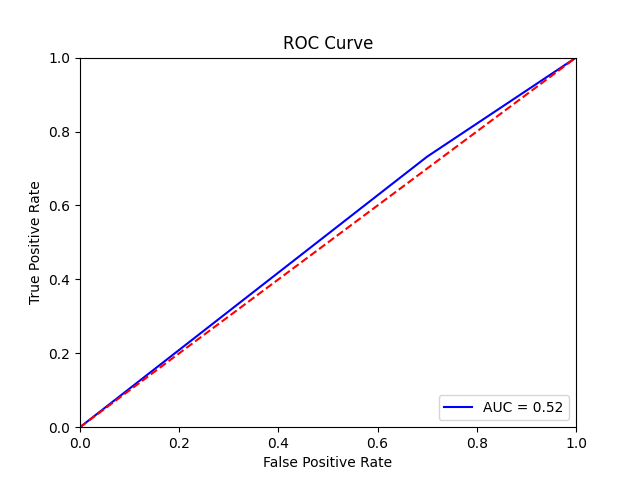

In [15]:
# Close previous plots; otherwise, will just overwrite and display again
plt.close()

# Get ROC curve and send it to Pandas so that we can plot it
roc_df = lor_evaluation_summary.roc.toPandas()

plt.plot(roc_df.FPR, roc_df.TPR, 'b',
         label=f'AUC = {round(lor_evaluation_summary.areaUnderROC, 2)}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()

%matplot plt

Note that if we wanted to try several different combinations of hyperparameters for our model (i.e. "tune" the model), MLlib has built-in classes for [searching a hyperparameter grid via cross validation](https://spark.apache.org/docs/latest/ml-tuning.html#cross-validation) (in parallel on our cluster), which you also saw in the DataCamp tutorial assigned for today.